In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

# Configuration for better visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Custom Loader to bypass ARFF strict errors

def load_messy_arff(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Find where the data starts (look for @data or @DATA)
    data_start_index = 0
    for i, line in enumerate(lines):
        if line.lower().strip().startswith('@data'):
            data_start_index = i + 1
            break
            
    # Read the data part using pandas, skipping the header lines
    # The data is comma-separated
    df = pd.read_csv(file_path, skiprows=data_start_index, header=None, on_bad_lines='skip')
    return df

# Load Data
filename = 'chronic_kidney_disease_full.arff' 
try:
    df = load_messy_arff(filename)
    print("Data loaded successfully using Custom Loader.")
    
    # Define Column Names manually 
    # (Since we skipped the ARFF header, we lost column names, so we add them back)
    col_names = [
        'age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 
        'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria', 
        'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium', 
        'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 
        'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 
        'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia', 'classification'
    ]
    
    # Check if column count matches
    if len(df.columns) == len(col_names):
        df.columns = col_names
        print("Column names applied correctly.")
    else:
        print(f"Warning: Column mismatch. Data has {len(df.columns)} cols, expected {len(col_names)}.")

    # Clean the Dirty Data (Fixing the exact cause of your error)
    # Removing 'tabs' and 'spaces' which caused the ValueError
    df = df.replace(to_replace={'\t': '', ' ': ''}, regex=True)
    df = df.replace(to_replace='?', value=np.nan)
    
    # Inspect the data
    print(f"\nShape: {df.shape}")
    print(df.head())

except FileNotFoundError:
    print(f"Error: Could not find {filename}. Make sure it is in the same folder.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully using Custom Loader.
Column names applied correctly.

Shape: (397, 25)
  age blood_pressure specific_gravity albumin sugar red_blood_cells  pus_cell  \
0  48             80            1.020       1     0             NaN    normal   
1   7             50            1.020       4     0             NaN    normal   
2  62             80            1.010       2     3          normal    normal   
3  48             70            1.005       4     0          normal  abnormal   
4  51             80            1.010       2     0          normal    normal   

  pus_cell_clumps    bacteria blood_glucose_random  ... packed_cell_volume  \
0      notpresent  notpresent                  121  ...                 44   
1      notpresent  notpresent                  NaN  ...                 38   
2      notpresent  notpresent                  423  ...                 31   
3         present  notpresent                  117  ...                 32   
4      notpresent  notprese

In [3]:
# Enforce Numeric Types 

# List of columns that MUST be numeric
numeric_cols = [
    'age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 
    'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium', 
    'potassium', 'hemoglobin', 'packed_cell_volume', 
    'white_blood_cell_count', 'red_blood_cell_count'
]

# Convert columns to numeric, turning errors (like strings) into NaN
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Numeric conversion successful.")
print(df[numeric_cols].dtypes)

Numeric conversion successful.
age                       float64
blood_pressure            float64
specific_gravity          float64
albumin                   float64
sugar                     float64
blood_glucose_random      float64
blood_urea                float64
serum_creatinine          float64
sodium                    float64
potassium                 float64
hemoglobin                float64
packed_cell_volume        float64
white_blood_cell_count    float64
red_blood_cell_count      float64
dtype: object


In [4]:
# Clean Target Variable

# Check unique values before mapping to ensure we catch everything
print("Unique target values before mapping:", df['classification'].unique())

# Map to binary (1 = CKD/Disease, 0 = NotCKD/Healthy)
# The regex cleaning in the previous step handled '\t', so simple mapping works
df['classification'] = df['classification'].map({'ckd': 1, 'notckd': 0})

print("Target mapped: ckd -> 1, notckd -> 0")
print(df['classification'].value_counts())

Unique target values before mapping: ['ckd' 'notckd']
Target mapped: ckd -> 1, notckd -> 0
classification
1    248
0    149
Name: count, dtype: int64


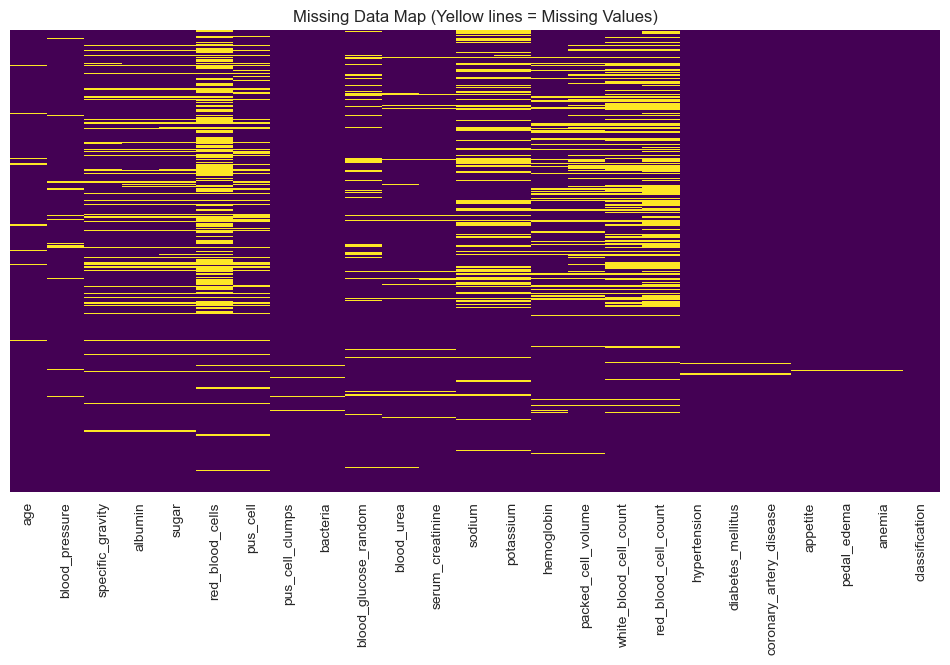


Top Features with Missing Data (%):
red_blood_cells           37.783375
red_blood_cell_count      32.745592
white_blood_cell_count    26.448363
potassium                 21.662469
sodium                    21.410579
packed_cell_volume        17.632242
pus_cell                  16.372796
hemoglobin                13.098237
sugar                     12.342569
specific_gravity          11.838791
dtype: float64


In [5]:
# Missing Value Analysis
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Map (Yellow lines = Missing Values)')
plt.show()

# Calculate percentage of missing data
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
print("\nTop Features with Missing Data (%):")
print(missing_percent.head(10))

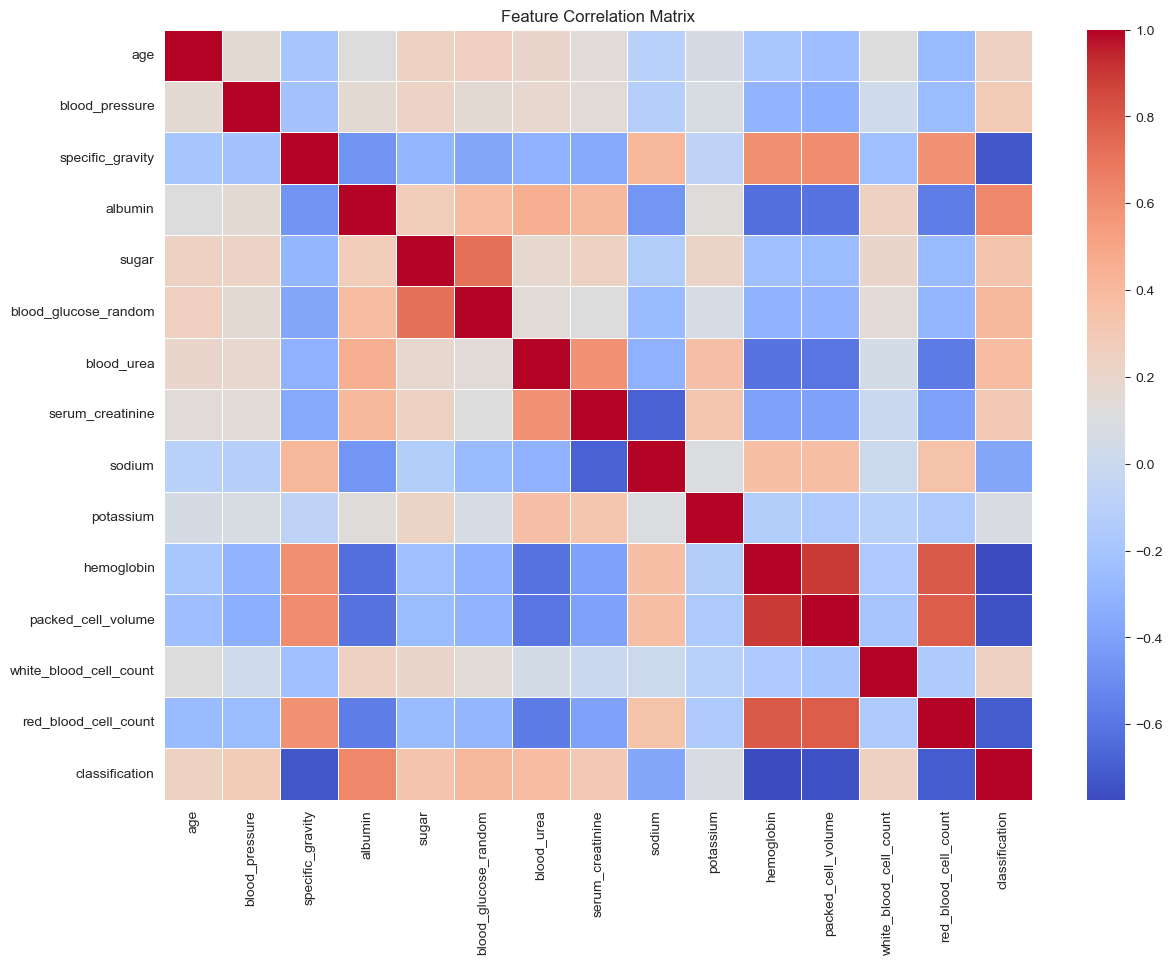

Top correlations with Classification (Disease):
classification            1.000000
albumin                   0.628283
blood_glucose_random      0.417318
blood_urea                0.384247
sugar                     0.338565
serum_creatinine          0.301250
blood_pressure            0.293096
white_blood_cell_count    0.236948
age                       0.235507
potassium                 0.083493
sodium                   -0.374453
red_blood_cell_count     -0.708553
specific_gravity         -0.731631
packed_cell_volume       -0.748184
hemoglobin               -0.773553
Name: classification, dtype: float64


In [6]:
# Correlation Heatmap
# Calculate correlation only on numeric columns
corr_matrix = df.corr(numeric_only=True)

# Plotting
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Which features correlate most with the disease (classification)?
print("Top correlations with Classification (Disease):")
print(corr_matrix['classification'].sort_values(ascending=False))

In [7]:
# Save Cleaned Baseline 
output_file = 'kidney_disease_cleaned.csv'
df.to_csv(output_file, index=False)
print(f"Baseline dataset saved to {output_file}")
print("Ready for Notebook 02: Feature Engineering & Imputation.")

Baseline dataset saved to kidney_disease_cleaned.csv
Ready for Notebook 02: Feature Engineering & Imputation.
